# Algorithm 

# Description 

The clusterThresh section of our pipeline takes in a binary volume containing clusters, thresholds the clusters by volume, changes those cluster into our object type Cluster, then returns a list of these Clusters. 

**Inputs:** 

input: the input Volume 

threshold: the upper fence for volume thresholding

**Outputs:** A list of objects of type Cluster


# The Code
**Imports**

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../code/functions/')
import tiffIO as tIO
import connectLib as cLib
import plosLib as pLib
import time
import scipy.ndimage as ndimage
import numpy as np
from scipy import sparse
from cluster import *

**The Actual Code:**

In [1]:
def clusterThresh(volume, lowerFence=0, upperFence=250):
    # the connectivity structure matrix
    s = [[[1 for k in xrange(3)] for j in xrange(3)] for i in xrange(3)]

    # find connected components
    labeled, nr_objects = ndimage.label(volume, s)

    #volume thresholding with upperFence
    mask = labeled > labeled.mean()
    sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
    mask_size = sizes > upperFence
    remove_pixel = mask_size[labeled]
    labeled[remove_pixel] = 0
    labeled, nr_objects = ndimage.label(labeled, s)

    if not lowerFence == 0:
        #volume thresholding with lowerFence
        mask = labeled > labeled.mean()
        sizes = ndimage.sum(mask, labeled, range(nr_objects + 1))
        mask_size = sizes < lowerFence
        remove_pixel = mask_size[labeled]
        labeled[remove_pixel] = 0
        labeled, nr_objects = ndimage.label(labeled, s)

    #convert labeled to Sparse
    sparseLabeledIm = np.empty(len(labeled), dtype=object)
    for i in range(len(labeled)):
        sparseLabeledIm[i] = sparse.csr_matrix(labeled[i])

    clusterList = []

    #converting to clusterList
    for label in range(1, nr_objects + 1):

        memberList = []

        for z in range(len(sparseLabeledIm)):
            memberListWithoutZ = np.argwhere(sparseLabeledIm[z] == label)
            memberListWithZ = [[z] + list(tup) for tup in memberListWithoutZ]
            memberList.extend(memberListWithZ)

        if not len(memberList) == 0:
            clusterList.append(Cluster(memberList))

    return clusterList

**I will be using the below cell for analyzing clusterThresh's Performance:**

In [3]:
def clusterAnalysis(rawData, lowerFence=0, upperFence=250, sliceVis=5):
    start_time = time.time()
    clusterList = clusterThresh(rawData, lowerFence, upperFence)
    volumeList = []
    print "time taken to label: " + str((time.time() - start_time)) + " seconds"
    print "Number of clusters: " + str(len(clusterList))
    displayIm = np.zeros_like(rawData)
    for cluster in range(len(clusterList)):
        volumeList.append(clusterList[cluster].getVolume())
        for member in range(len(clusterList[cluster].members)):
            z, y, x = clusterList[cluster].members[member]
            displayIm[z][y][x] = cluster
    print "Average Volume: " + str(np.mean(volumeList))

    plt.imshow(displayIm[sliceVis])
    plt.axis('off')
    plt.show()

## clusterThresh Conditions
clusterThresh would work well under the conditions that the input volume contains seperable, non-overlapping, sparse clusters and that the input volume is in binary-form (i.e. the values of the background voxels are 0's and the value of the foreground voxels are all positive integers).
clusterThresh would work poorly if the volume is not binary (i.e. the values of the background voxels are anything besides 0) or if the clusters are dense or in any way neighboring eachother.

## Predictable Data Sets

**The Good Data Set:**

**Description:** The good data set is a 1000 x 1000 x 100 volume containing 1875 clusters of size 125 with value of 1. Every other value in the volume is 0. 

**Plot:** I will plot the data at z=5 because it provides better visualization.

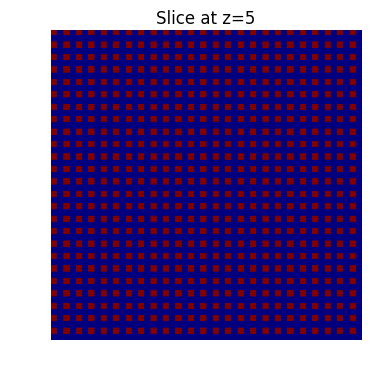

In [1]:
import numpy as np
import matplotlib.pyplot as plt

clusterGrid = np.zeros((100, 1000, 1000))
for i in range(40):
    for j in range(40):
        for k in range(40):
            clusterGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1
            
plt.imshow(clusterGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

**Prediction:** I predict that this volume will be perfectly segmented into 1875 clusters.

**The Difficult Data Set:**

**Description:** The good data set is a 1000 x 1000 x 100 volume containing 1875 clusters of size 125 with value of 2. Every other value in the volume is 1. In other words, the image is not binarized.

**Plot:** I will plot the data at z=5 because it provides better visualization.

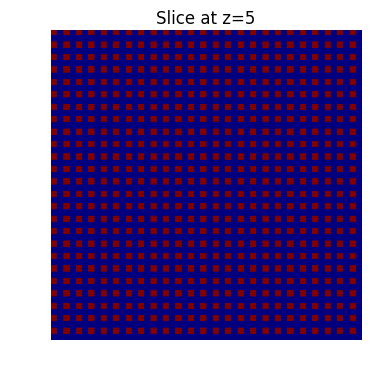

In [2]:
clusterGrid = clusterGrid + 1
plt.imshow(clusterGrid[5])
plt.axis('off')
plt.title('Slice at z=5')
plt.show()

**Prediction:** I predict that the entire volume will be segmented into one big component.

# Simulation
## Toy Data Generation

**The Good Data Set:**

In [26]:
simEasyGrid = np.zeros((100, 100, 100))
for i in range(4):
    for j in range(4):
        for k in range(4):
            simEasyGrid[20*(2*j): 20*(2*j + 1), 20*(2*i): 20*(2*i + 1), 20*(2*k): 20*(2*k + 1)] = 1

**Predicting what good data will look like:** I believe the good data will look like a grid of 27 cubes, 9 in each slice that contains clusters.

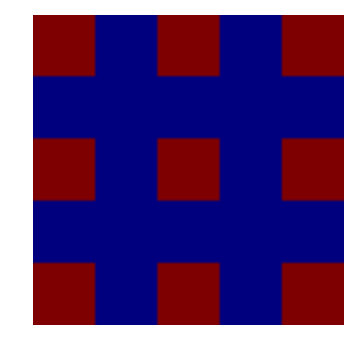

In [27]:
plt.imshow(simEasyGrid[5])
plt.axis('off')
plt.show()

**Visualization relative to prediction:** As predicted, the good data looks like a grid of cubes, 9 in each slice that contains clusters.

**The Difficult Data Set:**

In [28]:
simDiffGrid = simEasyGrid + 1

**Predicting what difficult data will look like:** I believe the good data will look like a grid of 27 cubes, 9 in each slice that contains clusters.

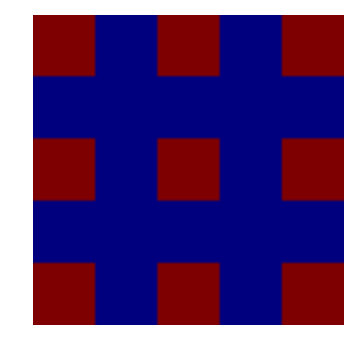

In [29]:
plt.imshow(simDiffGrid[5])
plt.axis('off')
plt.show()

**Visualization relative to prediction:** As predicted, the difficult data looks like a grid of cubes, 9 in each slice that contains clusters.
### Toy Data Analysis
**Good Data Prediction: ** 
I predict that the good data will segment the easy simulation into 27 clusters very quickly.

time taken to label: 1.10563111305 seconds
Number of clusters: 27
Average Volume: 8000.0


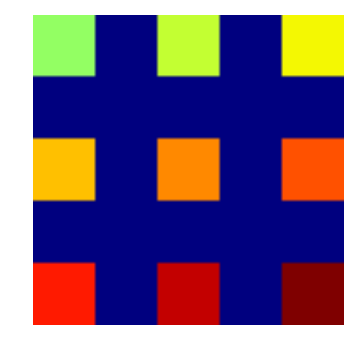

In [151]:
clusterAnalysis(simEasyGrid, 8000, sliceVis = 41)

**Results of Good Data Relative to Predictions:** As expected, the volume was segmented into 27 seperate clusters very quickly.

**Repeating the Good Data Simulation:**

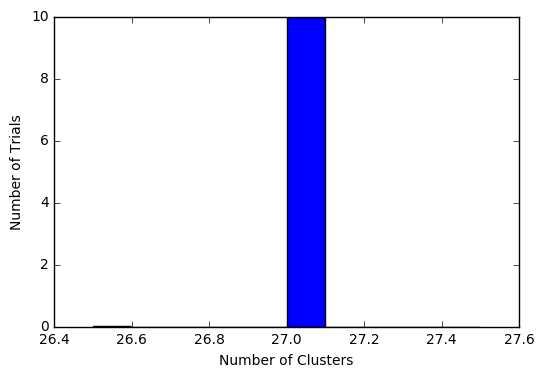

Average Number of Components on Easy Simulation Data:
	Expected: 27	Actual: 27.0


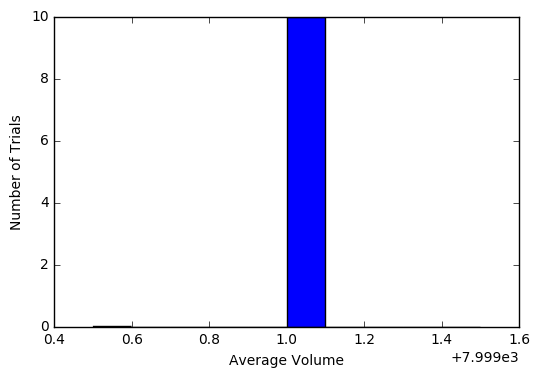

Average Volume on Easy Simulation Data:
	Expected: 8000	Actual: 8000.0


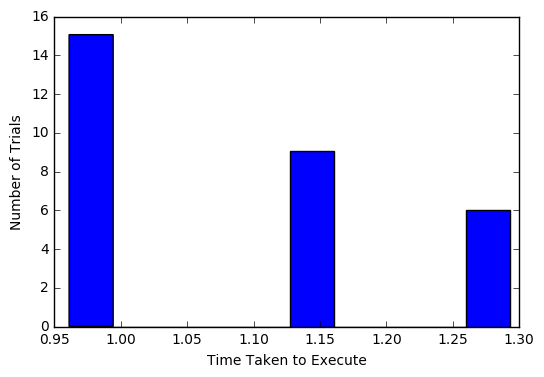

Average Time Taken to Execute: 1.08157720566


In [152]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
labeledNumClusters = []
volumesList = []
times = []

for i in range(10):
    start_time = time.time()
    clusterList = clusterThresh(simEasyGrid, 8000)
    times.append((time.time() - start_time))
    labeledNumClusters.append(len(clusterList))
    volumes = []
    for i in range(len(clusterList)):
        volumes.append(clusterList[i].getVolume())
    volumesList.append(np.mean(volumes))
    
    

pylab.hist(labeledNumClusters, normed=1)
pylab.xlabel('Number of Clusters')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Number of Components on Easy Simulation Data:\n\tExpected: 27\tActual: ' + str(np.mean(labeledNumClusters))

pylab.hist(volumesList, normed=1)
pylab.xlabel('Average Volume')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Volume on Easy Simulation Data:\n\tExpected: 8000\tActual: ' + str(np.mean(volumesList))

pylab.hist(times, normed=1)
pylab.xlabel('Time Taken to Execute')
pylab.ylabel('Number of Trials')
plt.show()
print 'Average Time Taken to Execute: ' + str(np.mean(times))

**Difficult Data Prediction:** I predict the difficult data will be segmented into 1 big cluster.

time taken to label: 2.66381001472 seconds
Number of clusters: 1
Average Volume: 1000000.0


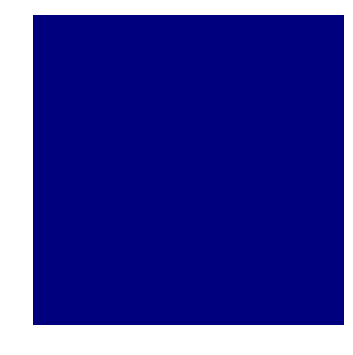

In [153]:
connectAnalysis(simDiffGrid, 8000, sliceVis = 41)

**Results of Difficult Data Result Relative to Prediction:** As expected, the volume was segmented into one big component.

**Repeating the Difficult Data Simulation:**

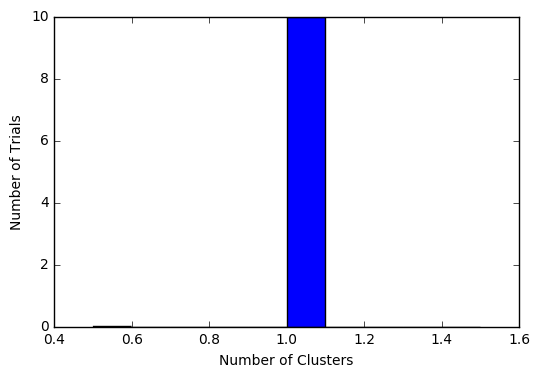

Average Number of Components on Difficult Simulation Data:
	Expected: 27	Actual: 1.0


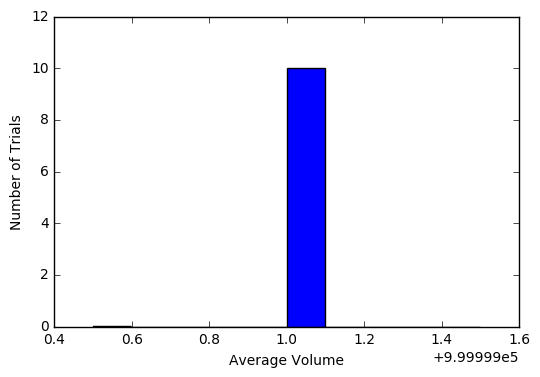

Average Volume on Difficult Simulation Data:
	Expected: 8000	Actual: 1000000.0


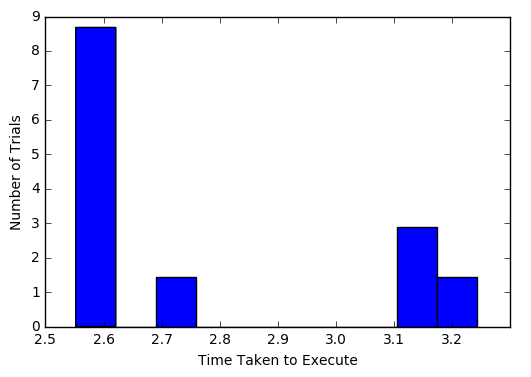

Average Time Taken to Execute: 2.77359979153


In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
import pylab
labeledNumClusters = []
volumesList = []
times = []

for i in range(10):
    start_time = time.time()
    clusterList = clusterThresh(simDiffGrid, 8000)
    times.append((time.time() - start_time))
    labeledNumClusters.append(len(clusterList))
    volumes = []
    for i in range(len(clusterList)):
        volumes.append(clusterList[i].getVolume())
    volumesList.append(np.mean(volumes))
    
    

pylab.hist(labeledNumClusters)
pylab.xlabel('Number of Clusters')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Number of Components on Difficult Simulation Data:\n\tExpected: 27\tActual: ' + str(np.mean(labeledNumClusters))

pylab.hist(volumesList, normed=1)
pylab.xlabel('Average Volume')
pylab.ylabel('Number of Trials')
pylab.show()
print 'Average Volume on Difficult Simulation Data:\n\tExpected: 8000\tActual: ' + str(np.mean(volumesList))

pylab.hist(times, normed=1)
pylab.xlabel('Time Taken to Execute')
pylab.ylabel('Number of Trials')
plt.show()
print 'Average Time Taken to Execute: ' + str(np.mean(times))

**Summary of Performances:** Connected Components performed extremely well on the easy simulation, correctly detecting 27 components very quickly for every trial. It also performed poorly as expected on the difficult simulation, connecting 1 component for every trial

# Real Data
## Synthetic Data Analysis
**Description:** Validation testing will be performed on a a 100x100x100 volume with a pixel intensity distribution approximately the same as that of the true image volumes (i.e., 98% background, 2% synapse). The synapse pixels will be grouped together in clusters as they would in the true data. Based on research into the true size of synapses, these synthetic synapse clusters will be given area of ~1 micron ^3, or about 139 voxels (assuming the synthetic data here and the real world data have identical resolutions). After the data goes through the algorithm, I will gauge performance based on the following:
number of clusters (should be about 500)
volumetric density of data (should be about 2% of the data)

**Plotting Raw Synthetic Data:**

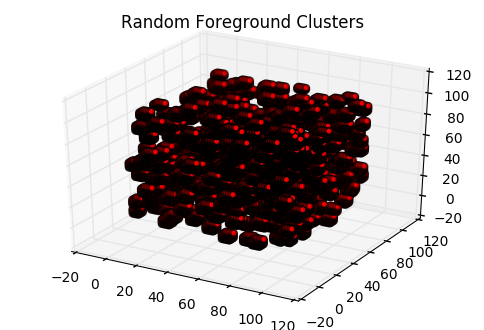

In [6]:
from random import randrange as rand
from mpl_toolkits.mplot3d import axes3d, Axes3D

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 5):
        for y in range(-1, 5):
            for x in range(-1, 5):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                if valid:
                    toPopulate.append(curPoint)
    return set(toPopulate)
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
    return volume

foreground = generateTestVolume()


#displaying the random clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = foreground.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.title('Random Foreground Clusters')
plt.show()

**Expectation for Synthetic Data:** I expect that the Connected Components will detect around 500 clusters.

**Running Algorithm on Synethetic Data:**

time taken to label: 5.79902601242 seconds
Number of clusters: 431
Average Volume: 264.250580046


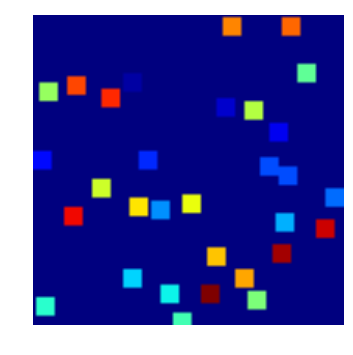

In [7]:
clusterAnalysis(foreground, lowerFence = 0, upperFence = 1000, sliceVis = 3)

# Real Data Analysis
I will first be testing to ensure that the Cluster Components functions on a slice of 5, and measuring the time it takes to ensure it is fast. I will also test the VolumeThreshold function, reporting the average volumes before and after the thresholding takes place, and plotting a slice to ensure that the volume threshold function is working properly. I will then repeat such tests on the entire volume.
# Slice of 5

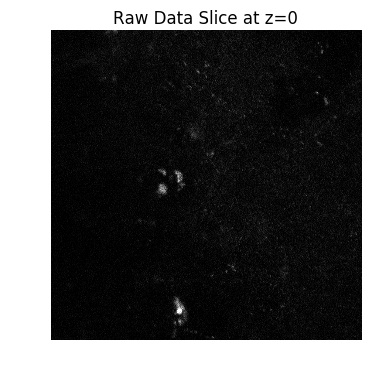

In [8]:
dataSubset = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][0:5]
plt.imshow(dataSubset[0], cmap="gray")
plt.axis('off')
plt.title('Raw Data Slice at z=0')
plt.show()

In [9]:
#finding the clusters after plosPipeline
plosOutSub = pLib.pipeline(dataSubset)

In [10]:
plosOutSubPow = np.power(plosOutSub, 1)

In [11]:
#binarize output of plos lib
bianOutSub = cLib.otsuVox(plosOutSubPow)

In [12]:
#dilate the output based on neigborhood size
bianOutSubDil = ndimage.morphology.binary_dilation(bianOutSub).astype(int)

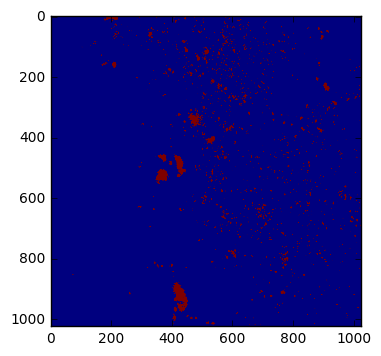

In [13]:
plt.imshow(bianOutSubDil[3])
plt.show()

## Using Cluster Thresh

time taken to label: 1.06238484383 seconds
Number of clusters: 549
Average Volume: 53.0255009107


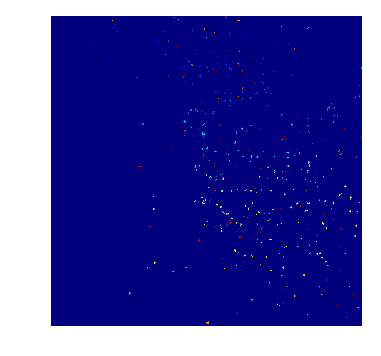

In [16]:
clusterAnalysis(bianOutSubDil, lowerFence=20, upperFence=150, sliceVis=3)

## The Results From Disparate Methods

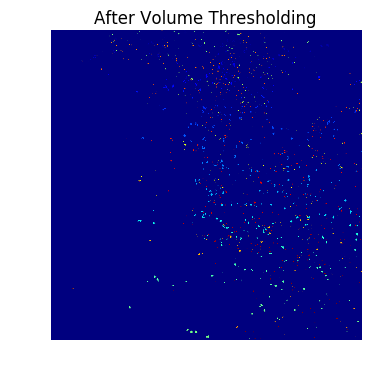

In [85]:
plt.imshow(im.labeledIm[3])
plt.title('After Volume Thresholding')
plt.axis('off')
plt.show()

In [87]:
print "num volumes: " + str(len(im.getVolumes()))
print "num clusters: " + str(im.numClusters)
print "num centroids: " + str(len(im.getCentroids()))

num volumes: 1754
num clusters: 1754
num centroids: 1754


# Entire Volume

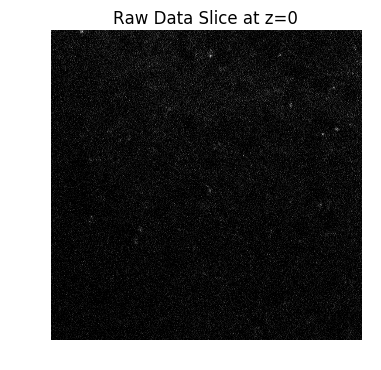

In [17]:
dataFull = tIO.unzipChannels(tIO.loadTiff('../data/SEP-GluA1-KI_tp1.tif'))[0][260: 279]
plt.imshow(dataFull[10], cmap="gray")
plt.axis('off')
plt.title('Raw Data Slice at z=0')
plt.show()

In [18]:
#finding the clusters after plosPipeline
plosOutFull = pLib.pipeline(dataFull)

In [19]:
#binarize output of plos lib
bianOutFull = cLib.otsuVox(plosOutFull)

In [20]:
#dilate the output based on neigborhood size
bianOutFullDil = ndimage.morphology.binary_dilation(bianOutFull).astype(int)

time taken to label: 64.4984109402 seconds
Number of clusters: 18882
Average Volume: 20.9649401546


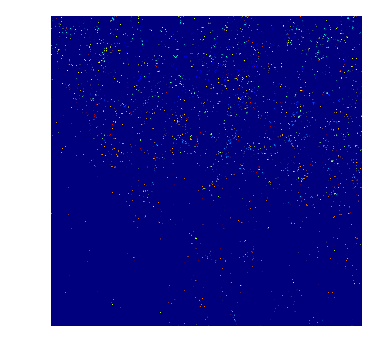

In [23]:
clusterAnalysis(bianOutFullDil, upperFence=200, sliceVis=3)